<a href="https://colab.research.google.com/github/ye0njinkim/EEE4178_2023_Hands_On/blob/main/2023_Day5_Transformer_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# ``nn.Transformer`` 와 torchtext로 언어 번역하기

이 튜토리얼에서는,
    - Transformer(트랜스포머)를 사용한 번역 모델을 바닥부터 학습하는 방법을 배워보겠습니다.
    - [Multi30k](http://www.statmt.org/wmt16/multimodal-task.html#task1)_
      데이터셋을 사용하여 독일어(German)를 영어(English)로 번역하는 모델을 학습해보겠습니다.


## 데이터 구하고 처리하기

[torchtext 라이브러리](https://pytorch.org/text/stable/)_\ 에는 언어 번역 모델을
생성하기 위한 데이터셋을 쉽게 만들 수 있는 도구들이 있습니다.
이 튜토리얼에서는 torchtext의 내장(inbuilt) 데이터셋을 어떻게 사용하고,
원시(raw) 텍스트 문장을 토큰화(tokenize)하고, 토큰을 텐서로 수치화하는 방법을
살펴보겠습니다. 출발어(source)-도착어(target) 원시(raw) 문장을 생성하기 위해서는
[torchtext 라이브러리의 Multi30k 데이터셋](https://pytorch.org/text/stable/datasets.html#multi30k)_
을 사용하겠습니다.

torchtext 데이터셋에 접근하기 전에, https://github.com/pytorch/data 을 참고하여 torchdata를 설치하시기 바랍니다.




출발어(source)와 목적어(target)의 토크나이저(tokenizer)를 생성합니다.
아래 필요 사항(dependency)을 모두 설치해주세요.

```python
pip install -U torchdata
pip install -U spacy
python -m spacy download en_core_web_sm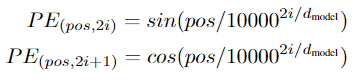
python -m spacy download de_core_news_sm
```


In [ ]:
pip install -U torchdata

In [ ]:
pip install -U spacy

pip install 하고 런타임 재시작 해야함

In [1]:
import subprocess

subprocess.call(['python', '-m', 'spacy', 'download', 'de_core_news_sm'])

0

In [2]:
import subprocess

subprocess.call(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])

0

In [7]:
pip uninstall portalocker

Found existing installation: portalocker 2.8.2
Uninstalling portalocker-2.8.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/portalocker-2.8.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/portalocker/*
Proceed (Y/n)? Y
  Successfully uninstalled portalocker-2.8.2


In [9]:
pip install portalocker

  Using cached portalocker-2.8.2-py3-none-any.whl (17 kB)


In [3]:
from torchtext.data.utils import get_tokenizer #텍스트를 token화 하는데 사용
from torchtext.vocab import build_vocab_from_iterator #Iterator로부터 vocabulary를 구축하는데에 사용
from torchtext.datasets import multi30k, Multi30k #독일어 / 영어 문장 쌍을 포함하는 translation task를 위한 dataset
from typing import Iterable, List #type hinting


# 원본 데이터의 링크가 동작하지 않으므로 데이터셋의 URL을 수정해야 합니다.
# 더 자세한 내용은 https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 을 참고해주세요.
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
#URL 설정

SRC_LANGUAGE = 'de' #source language
TGT_LANGUAGE = 'en' #target language

# Place-holders
token_transform = {}
vocab_transform = {}
#token과 vocabulary를 저장하기 위함.

In [4]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# 토큰 목록을 생성하기 위한 헬퍼(helper) 함수
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# 특수 기호(symbol)와 인덱스를 정의합니다
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# 토큰들이 어휘집(vocab)에 인덱스 순서대로 잘 삽입되어 있는지 확인합니다
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # 학습용 데이터 반복자(iterator)
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # torchtext의 Vocab(어휘집) 객체 생성
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# ``UNK_IDX`` 를 기본 인덱스로 설정합니다. 이 인덱스는 토큰을 찾지 못하는 경우에 반환됩니다.
# 만약 기본 인덱스를 설정하지 않으면 어휘집(Vocabulary)에서 토큰을 찾지 못하는 경우
# ``RuntimeError`` 가 발생합니다.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

## Transformer를 사용한 시퀀스-투-시퀀스(Seq2Seq) 신경망

Transformer(트랜스포머)는 기계번역 작업(task)을 위해
["Attention is all you need"](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)_
논문에 소개된 Seq2Seq 모델입니다.
아래에서 Transformer를 사용한 Seq2Seq 신경망을 만들어보겠습니다.
신경망은 세 부분으로 구성되는데, 첫번째 부분은 임베딩 계층(embedding layer)입니다.
이 계층은 입력 인덱스의 텐서를 입력 임베딩의 해당하는 텐서로 변환합니다.
이러한 임베딩은 입력 토큰의 위치 정보(position information)를 모델에 전달하기 위해
위치 인코딩(positional encoding)을 추가합니다.
두번째 부분은 실제 [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)_ 모델입니다.
마지막으로 Transformer 모델의 출력을 선형 계층에 통과시켜 도착어의 각 토큰에 대한 정규화되지 않은
확률(un-normalized probability)로 제공합니다.




In [5]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #디바이스 GPU로

<a href="https://imgbb.com/"><img src="https://i.ibb.co/x19d3vq/positionalencoding.png" alt="positionalencoding" border="0"></a>

In [6]:
# 단어 순서 개념(notion)을 토큰 임베딩에 도입하기 위한 위치 인코딩(positional encoding)을 위한 헬퍼 모듈(Module)
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):  #embedding 크기, dropout 비율, 최대 시퀀스 길이
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [7]:
# 입력 인덱스의 텐서를 해당하는 토큰 임베딩의 텐서로 변환하기 위한 헬퍼 모듈(Module)
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size): #vocabulary size, embedding size
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size) #embedding 뽑고 크기 조정

In [8]:
# Seq2Seq 신경망
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1): #인코더 디코더 layer(층)수, embedding 크기, head수(multi head), vocabulary size, feed-foward network 크기, dropout
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size) #embedding을 가지고 target vocabulary에서 어떤 단어인지 찾기 위함!
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

학습하는 동안, 모델이 예측할 때 정답(이후 출현하는 단어)을 보지 못하도록 하는
후속 단어 마스크(subsequent word mask)가 필요합니다. 또한, 출발어와 도착어의 패딩(padding) 토큰들
또한 숨겨야 합니다. 아래에 두 가지 모두를 처리할 함수를 정의해보겠습니다.




In [9]:
def generate_square_subsequent_mask(sz): #길이자 sz인 aequence에 대한 subsequent word mask
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1) #triu? -> 대각선 위의 요소는 1 아래는 0. 디코더가 미래의 단어를 보지 않도록.
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)) #mask가 0이면 -inf로. softmax 계산 시 해당 위치를 무시하게.
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len) #target sequence에 대한 후속 마스크 생성.
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool) # soruce sequence에 대한 마스크. 모든 값 0
    #source sequence는 전체 내용 고려해야.

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1) #padding 식별
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

이제 모델의 매개변수를 정의하고 객체를 생성(instantiate)해보겠습니다.
아래처럼 학습 단계에서 사용할 손실 함수(loss function)를 교차 엔트로피 손실(cross-entropy loss)로 정의하고,
옵티마이저(optimizer)도 정의합니다.




In [10]:
torch.manual_seed(0)
#다른 시드도 고정해야 진짜 고정임..
#seed everything 구글링.

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3 #parameter set

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
#초기화.

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## 대조(Collation)

위의 ``데이터 구하고 처리하기`` 장에서 봤듯이, 데이터 반복자(iterator)는 원시 문자열의 쌍을 생성합니다.
이 문자열 쌍들을 이전에 정의한 ``Seq2Seq`` 신경망에서 처리할 수 있도록 텐서 묶음(batched tensor)으로 변환해야 합니다.
이제 원시 문자열들의 묶음(batch)을 텐서 묶음으로 변환하여 모델에 직접 전달할 수 있도록 하는 대응어(collate) 함수를
정의해보겠습니다.




In [11]:
from torch.nn.utils.rnn import pad_sequence

# 순차적인 작업들을 하나로 묶는 헬퍼 함수
def sequential_transforms(*transforms): #임의 개수의 변환함수를 인수로.
    def func(txt_input): # 입력 텍스트에 대해 각 변환을 순차적으로 적용
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# BOS/EOS를 추가하고 입력 순서(sequence) 인덱스에 대한 텐서를 생성하는 함수 #BOS, 입력 토큰 ID, EOS 토큰 연결
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# 출발어(src)와 도착어(tgt) 원시 문자열들을 텐서 인덱스로 변환하는 변형(transform)
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # 토큰화(Tokenization)
                                               vocab_transform[ln], # 수치화(Numericalization) 단어를 그대로 사용할 수 없으니..
                                               tensor_transform) # BOS/EOS를 추가하고 텐서를 생성


# 데이터를 텐서로 조합(collate)하는 함수
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch: #배치 내의 데이터에 대해
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))) #줄바꿈 문자 제거
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX) #동일 길이 패딩
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

각 에폭(epoch)마다 호출할 학습 및 검증(evaluation) 단계를 정의해보겠습니다.




In [12]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0 #loss 저장 변수
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :] #EOS 제외

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input) #마스크 생성

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask) #model foward 결과

        optimizer.zero_grad()

        tgt_out = tgt[1:, :] #실제 타겟 출력(EOS 제외)
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) #loss계산
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

이제 모델 학습을 위한 모든 요소가 준비되었습니다. 학습을 해보겠습니다!




In [13]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# 탐욕(greedy) 알고리즘을 사용하여 출력 순서(sequence)를 생성하는 함수
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask) #data encoding
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE) #start symbol로 초기화된 target sequence 생성
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)) #target mask 생성
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask) #현재 target sequence에 대한 출력을 decoder로 생성
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1]) #가장 최근에 생성된 단어에 대한 예측 확률 계산(linear layer 결과)
        _, next_word = torch.max(prob, dim=1) #제일 높은 확률 선택
        next_word = next_word.item() #선택 단어 현재 시퀀스에 추가

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys #ys에 순서대로 채우고 return


# 입력 문장을 도착어로 번역하는 함수
def translate(model: torch.nn.Module, src_sentence: str): #greedy decode로 실제 model의 출력을 문장으로 변환
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "") #eos, bos 제거

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 1, Train loss: 5.344, Val loss: 4.106, Epoch time = 45.160s
Epoch: 2, Train loss: 3.761, Val loss: 3.309, Epoch time = 43.432s
Epoch: 3, Train loss: 3.157, Val loss: 2.887, Epoch time = 45.233s
Epoch: 4, Train loss: 2.767, Val loss: 2.640, Epoch time = 43.585s
Epoch: 5, Train loss: 2.477, Val loss: 2.442, Epoch time = 43.583s
Epoch: 6, Train loss: 2.247, Val loss: 2.306, Epoch time = 44.818s
Epoch: 7, Train loss: 2.055, Val loss: 2.207, Epoch time = 43.943s
Epoch: 8, Train loss: 1.893, Val loss: 2.114, Epoch time = 43.542s
Epoch: 9, Train loss: 1.754, Val loss: 2.054, Epoch time = 44.335s
Epoch: 10, Train loss: 1.628, Val loss: 2.008, Epoch time = 44.395s
Epoch: 11, Train loss: 1.520, Val loss: 1.961, Epoch time = 43.597s
Epoch: 12, Train loss: 1.420, Val loss: 1.958, Epoch time = 43.500s
Epoch: 13, Train loss: 1.330, Val loss: 1.972, Epoch time = 44.887s
Epoch: 14, Train loss: 1.245, Val loss: 1.978, Epoch time = 43.406s
Epoch: 15, Train loss: 1.173, Val loss: 1.929, Epoch time

In [14]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people standing in front of an igloo 


## 참고자료

1. Attention is all you need 논문.
   https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
2. Transformer에 대한 설명. https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding


